# Data enrichment

This notebook aims to enrich the data to extract interesting metrics on broadcasters who have broadcast at least once with a Vtuber tag. We focus on the data that emanates from the videos available on each broadcaster's channel.

To do this, we first need to query all these videos.

And then we have to understand them at least a little bit.

## For general purpose

In [1]:
import requests
import json
import pandas as pd
import os

 # The .json with the CLIENT_ID and the TOKEN
with open('../twitch_credentials.json', mode='r') as f:
    twitch_credentials = json.load(f)

    # Twitch API variables
    CLIENT_ID = twitch_credentials['CLIENT_ID']
    TOKEN = twitch_credentials['TOKEN']
    
headers = {"Authorization":"Bearer " + TOKEN, "Client-Id":CLIENT_ID}

In [2]:
oldAPIStreams = pd.read_csv('../Data/aggregated/twitch_streams_vtuber_tagIds.csv')
newAPIStreams = pd.read_csv('../Data/aggregated/twitch_streams_vtuber_tagIds_tags.csv')

streams = pd.concat([oldAPIStreams, newAPIStreams], ignore_index=True)
users_id = streams.loc[:, ['user_id']].drop_duplicates()

## Querying videos

In [3]:
from datetime import datetime

url = 'https://api.twitch.tv/helix/videos?first=100&user_id='
ratelimit = []

def get_user_videos(user_df):
    user_id = user_df['user_id'].iloc[0]
    df_response = None
    
    try:
        response = requests.get(url + str(user_id), headers=headers)
        df_response = pd.DataFrame(response.json()["data"])

        ratelimit.append(response.headers['Ratelimit-Remaining'])

        if 'stream_id' not in df_response.columns and not df_response.empty:
            print(f"stream_id not in columns of user {user_id} - 1")
            return None

        # While there are other pages to get
        while len(response.json()["pagination"]) > 0 :
                response = requests.get(url + str(user_id) + "&after=" + response.json()["pagination"]["cursor"], headers=headers)
                df_response = pd.concat([df_response, pd.DataFrame(response.json()["data"])])

                ratelimit.append(response.headers['Ratelimit-Remaining'])

                if 'stream_id' not in df_response.columns:
                    print(f"stream_id not in columns of user {user_id} - 2")
                    return None
        
        return df_response                

    except Exception as e:
        print(f"Exception [{e}] with user {user_id}")
        return None

In [4]:
all_videos = users_id.groupby('user_id').apply(get_user_videos).reset_index(drop=True)

Just checking the Ratelimit-Remaining to be sure...

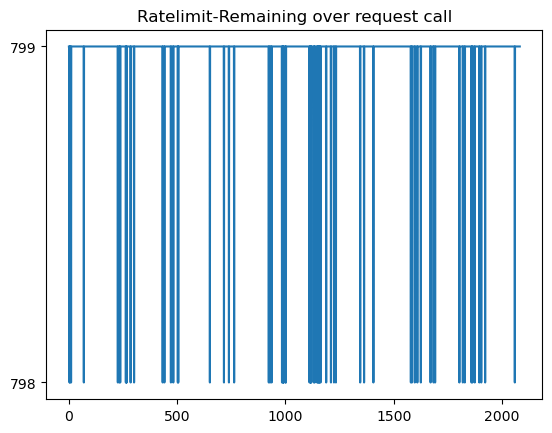

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(x=range(len(ratelimit)), y=ratelimit, )
plt.title('Ratelimit-Remaining over request call');

In [6]:
#all_videos.to_csv('./twitch_videos_vtuber_broadcaster.csv', index=False)

In [7]:
all_videos.groupby("user_name").view_count.sum().sort_values().tail()

user_name
Octoloth       47617.0
vanex_x        59636.0
RavenCross     68580.0
MiyunaTV       80612.0
RiriMiaou     119311.0
Name: view_count, dtype: float64

Just checking the memory size needed to store the dataFrame videos:

In [8]:
import sys

def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                    all_videos: 34.7 MiB
                 oldAPIStreams:  3.5 MiB
                 newAPIStreams:  2.7 MiB
                     ratelimit: 17.8 KiB
              user_ids_streams: 16.6 KiB
                           _i3:  1.3 KiB
                           _i8:  588.0 B
                             _:  555.0 B
                            _7:  555.0 B
                           _i1:  437.0 B


The idea would be to run a python bot that retrieves the videos every day. And memory is a consideration. With only a few dozen MiB, we are far from any RAM problems.
The python bot is available : [`../TwitchBot/twitch_video_bot.py`](../TwitchBot/twitch_video_bot.py).

## Metrics

Time to try some ideas and see !

In [214]:
csv_path = '../Data/scattered/videos/'
videos_path = csv_path + max([file for file in os.listdir(path=csv_path) if file.endswith('csv')])
videos = pd.read_csv(videos_path)

We filter `videos` so that its content can potentially coincide with streams captured by *twitch_stream_bot*.
The goal is to keep only those videos that must meet the following condition: if a video comes from a stream that was not detected by *twitch_stream_bot*, that stream did not have a Vtuber tag.

In [215]:
first_started = newAPIStreams.iloc[0]['started_at']
last_started = newAPIStreams.iloc[-1]['started_at']

relevant_videos = videos[videos.created_at.between(first_started, last_started) & (videos.type == 'archive')]

def to_timedelta(row):
    row['duration'] = pd.to_timedelta(row['duration'])
    return row


relevant_videos = relevant_videos.apply(to_timedelta, axis='columns')

print(f"There are {relevant_videos.shape[0]} videos which are stream archive from streams created during the twitch_stream_bot recording window.")

There are 4091 videos which are stream archive from streams created during the twitch_stream_bot recording window.


Last filter to make sure that if a stream was broadcast with a Vtuber tag, the *twitch_stream_bot* would have detected it: the stream duration !

We need to filter out streams that are too short, but we don't want to lose too much data.
So the first step is to understand the distribution of stream duration.

In [216]:
import numpy as np

def get_repartition_funcGraph(time_step, start, end):
    time_range = pd.timedelta_range(start=start, end=end, freq=time_step)

    streams_prop = np.zeros(len(time_range))

    for i in range(len(time_range)):
        streams_prop[i] = relevant_videos[relevant_videos.duration <= time_range[i]].shape[0]

    streams_prop /= relevant_videos.shape[0]

    return time_range, streams_prop

First, a global overview :

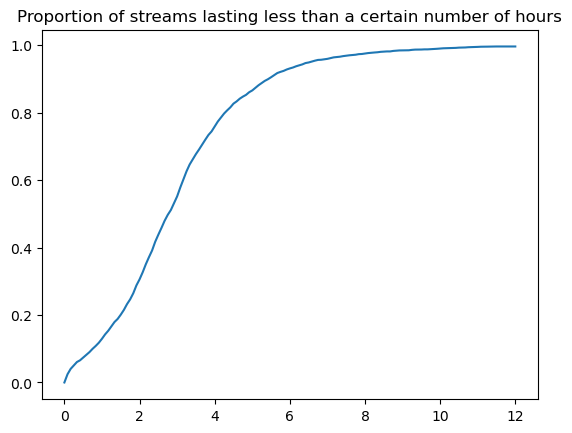

In [217]:
import seaborn as sns
import matplotlib.pyplot as plt

time_range, streams_prop = get_repartition_funcGraph(pd.Timedelta(minutes=5), start='0s', end='12h')
sns.lineplot(x=time_range.total_seconds() / 3600, y=streams_prop, )
plt.title('Proportion of streams lasting less than a certain number of hours');

More precisely :

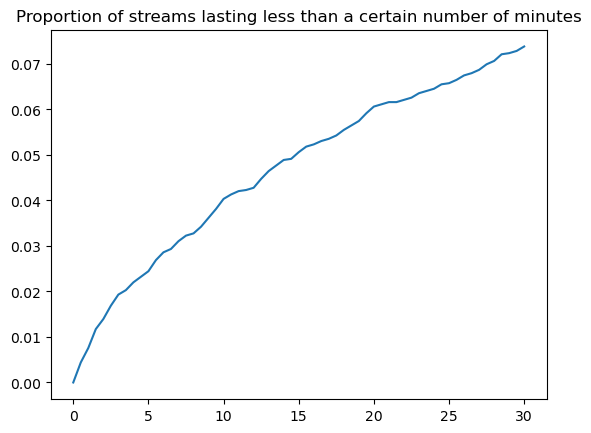

In [218]:
time_range, streams_prop = get_repartition_funcGraph(pd.Timedelta(seconds=30), start='0s', end='30m')
sns.lineplot(x=time_range.total_seconds() / 60, y=streams_prop, )
plt.title('Proportion of streams lasting less than a certain number of minutes');

A call to the *twitch_stream_bot* subroutine takes a maximum of 2 minutes. So if we drop streams that last less than 15 minutes, we only lose about 5% of our data but we give *twitch_stream_bot* at least 7-8 chances to detect streams that have a Vtuber tag.

This should be more than enough.

In [219]:
relevant_videos = relevant_videos[relevant_videos.duration > pd.Timedelta(minutes=15)]

print(f"There are {relevant_videos.shape[0]} videos that are stream archives from streams that should have been processed by the twitch_stream_bot")

There are 3884 videos that are stream archives from streams that should have been processed by the twitch_stream_bot


Now we can calculate the percentage for each broadcaster of the streams that had a Vtuber tag.

In [220]:
def calculate_vtuber_stream_percentage(user_df):
    result = user_df.iloc[0][['user_id', 'user_login', 'user_name']]
    user_stream_ids = user_df.loc[:,['stream_id']].rename(columns={'stream_id':'id'})
    nb_streams = user_stream_ids.shape[0]
    nb_Vtuber_tag_streams = user_stream_ids.merge(newAPIStreams).shape[0]

    result['vtuber_tag_percentage'] = nb_Vtuber_tag_streams / nb_streams
    result['stream_number'] = nb_streams
    return result

In [221]:
user_stats = relevant_videos.groupby(['user_id']).apply(calculate_vtuber_stream_percentage).reset_index(drop=True)

We can plot the CDF (cumulative distribution function) in order to visualise `vtuber_tag_percentage`.

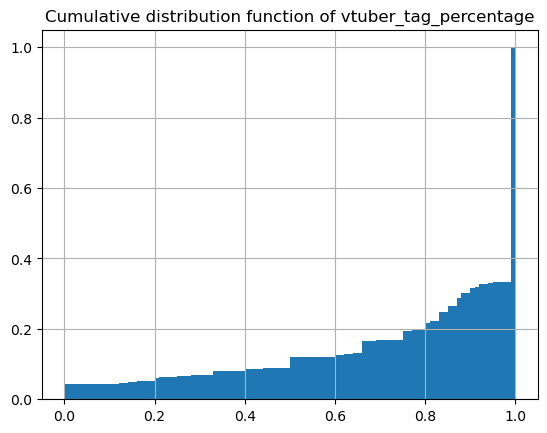

In [222]:
user_stats.vtuber_tag_percentage.hist(cumulative=True, density=1, bins=100).plot()
plt.title('Cumulative distribution function of vtuber_tag_percentage');

And in order to check the quality of `vtuber_tag_percentage`, we need to know how many streams were used to calculate the proportion.

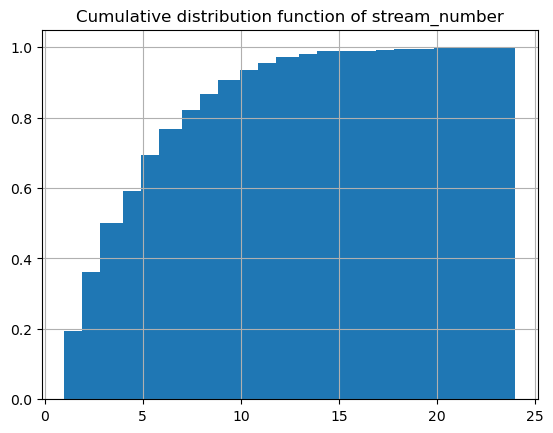

In [223]:
user_stats['stream_number'].hist(cumulative=True, density=1, bins=100).plot()
plt.title('Cumulative distribution function of stream_number');

As we can see from the diagram, many users have not yet broadcast enough streams to have relevant statistics. We have to wait until we collect more data.